In [1]:
!pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.4.2.tar.gz (37.3 MB)
  Preparing metadata (setup.py) ... done
  Using cached Keras-2.4.3-py2.py3-none-any.whl.metadata (1.5 kB)
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.5.0 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.5.0


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV4'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

# Imports

In [3]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib

2025-05-28 19:51:08.160485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748461868.188835    1351 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748461868.197687    1351 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 19:51:08.230374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset

## Dataset in a pandas Dataframe

In [4]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [5]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [6]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.keras'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [7]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [8]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [9]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [10]:
model = neural_networks.freehand_v4(in_shp)

model.summary()

I0000 00:00:1748461877.823988    1351 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 128, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2, 128, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 64, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 64, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 64, 256)     │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 64, 32)      │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 64, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 32, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,359 (1.28 MB)

 Trainable params: 334,749 (1.28 MB)

 Non-trainable params: 610 (2.38 KB)

### Train the model

In [11]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


/opt/conda/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 2, 128))
  warnings.warn(msg)
I0000 00:00:1748461885.132833    1550 service.cc:148] XLA service 0x7f9af4007070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748461885.132909    1550 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-05-28 19:51:25.214583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748461885.587178    1550 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-05-28 19:51:26.461871: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 33.53GiB with freed_by_count=0. The

  5/146 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 2.7280

I0000 00:00:1748461890.423440    1550 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 1.9761

2025-05-28 19:51:39.100845: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 33.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
E0000 00:00:1748461900.023063    1546 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748461900.227628    1546 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 1.9741 - val_loss: 3.8783
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1.3876 - val_loss: 6.4596
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1.3352 - val_loss: 7.3245
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1.3150 - val_loss: 5.7418
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.2685 - val_loss: 2.8420
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.2485 - val_loss: 1.2189
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.2335 - val_loss: 1.1970
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1.2237 - val_loss: 1.1987
Epoch 9/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.2022 - val_loss: 1.1861
Epoch 10/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 1.1972 - val_loss: 1.1791
Epoch 11/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.2187 - val_loss: 1.1750
Epoch 12/100
146/146 ━━━━━━━━━━━━━━━━━━━━

# Evaluate and Plot Model Performance

In [12]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0497

2025-05-28 19:53:42.342733: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0533
1.1488438844680786


## Loss

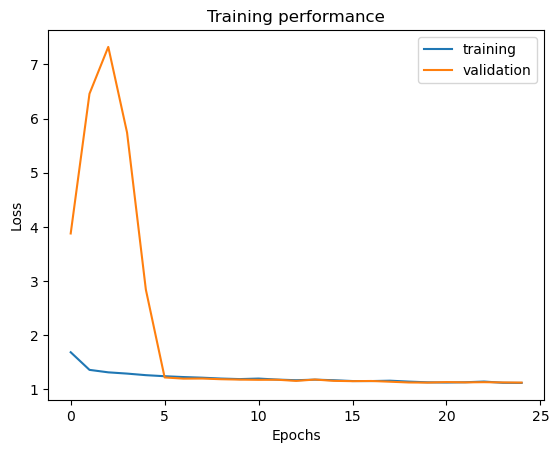

In [13]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

/opt/conda/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1024, 2, 128))
  warnings.warn(msg)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


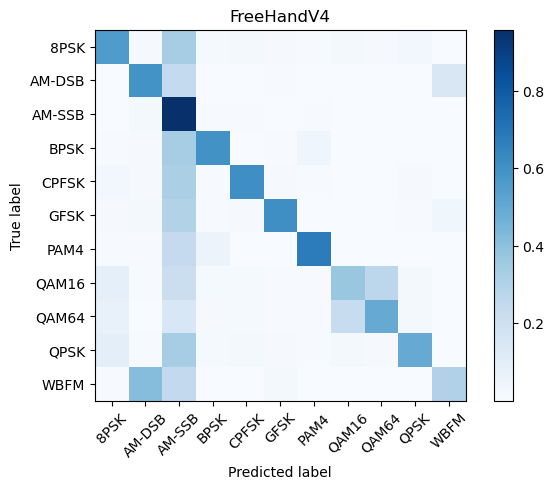

In [14]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Overall Accuracy:  0.08543833580980684
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Overall Accuracy:  0.09390018484288355
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Overall Accuracy:  0.09685401201838105
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Overall Accuracy:  0.1106816584680253
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Overall Accuracy:  0.1347543352601156
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Overall Accuracy:  0.20909416398138203
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Overall Accuracy:  0.3310641347187388
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Overall Accuracy:  0.4949127906976744
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Overall Accuracy:  0.6343627973020944
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Overall Accuracy:  0.7483824586628325
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Overall Accuracy:  0.8140885984023238
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Overall Accuracy:  0.8424089433826181
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Overall Accuracy:  0.84895635

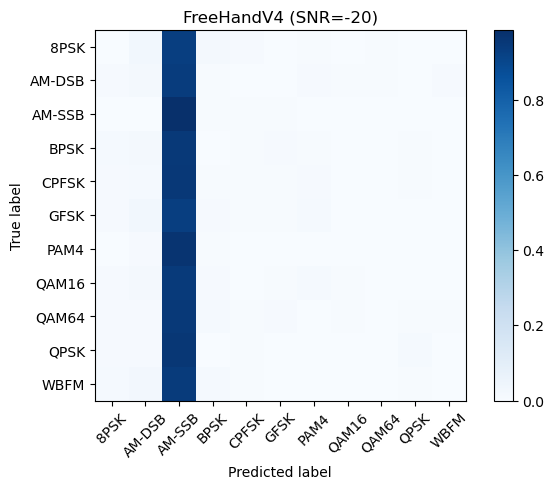

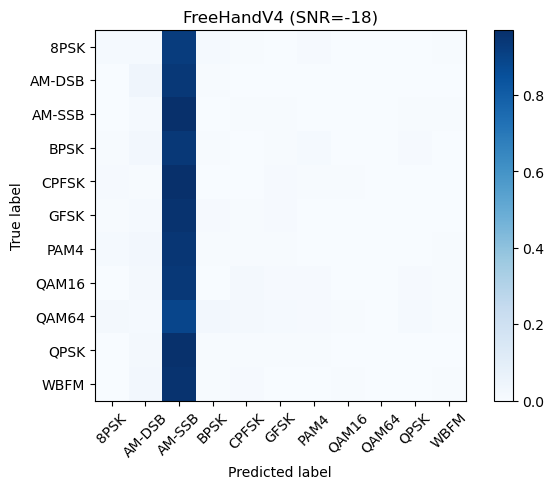

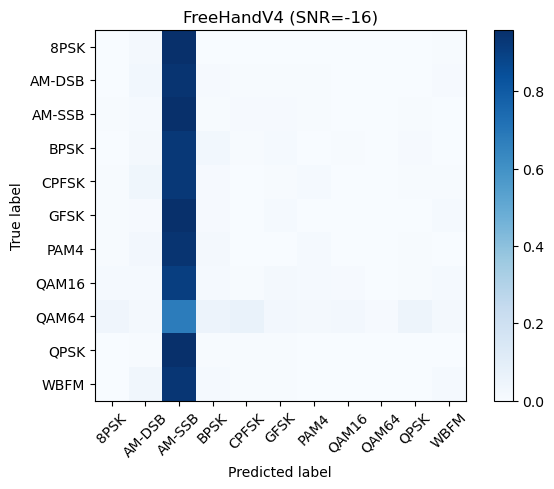

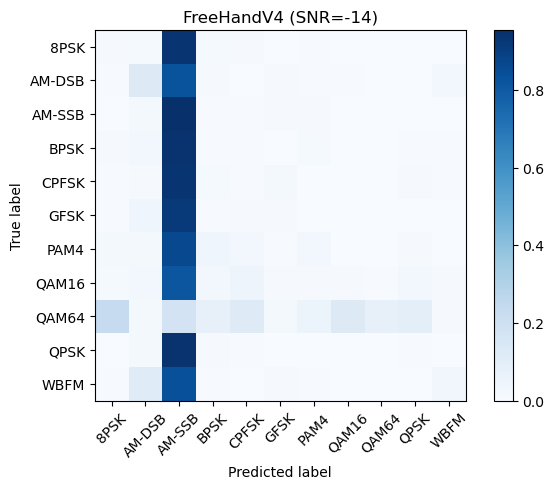

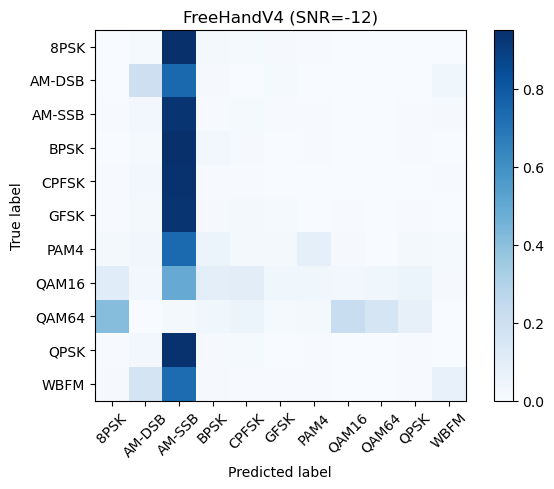

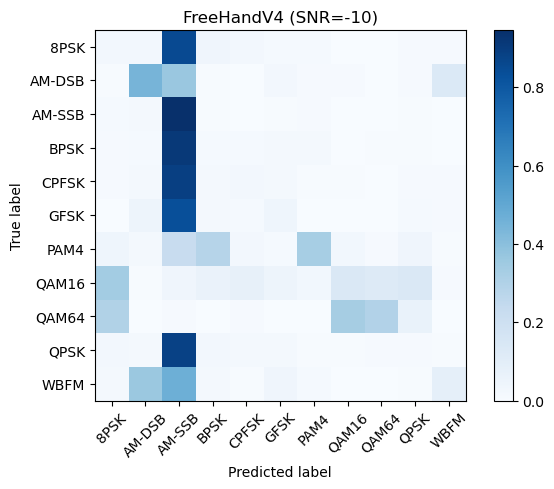

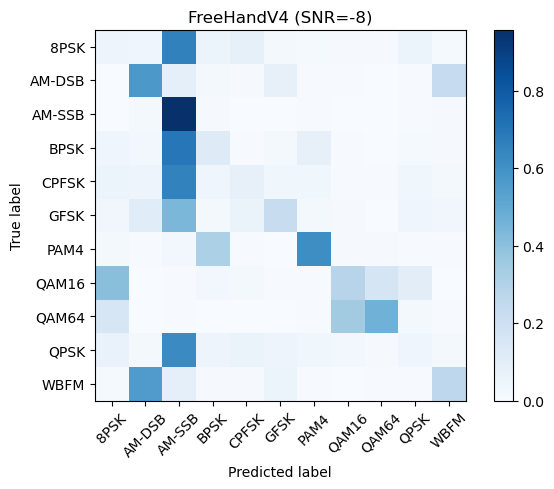

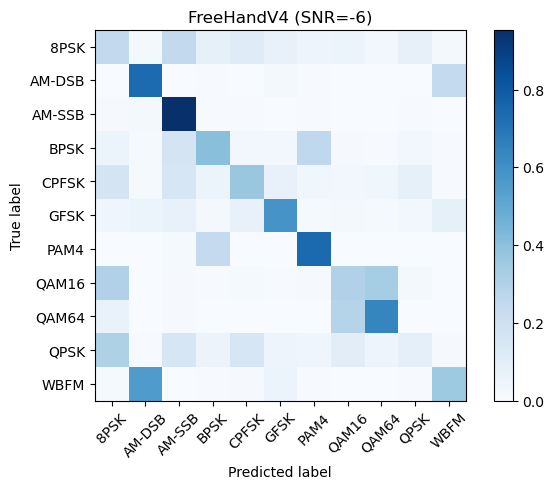

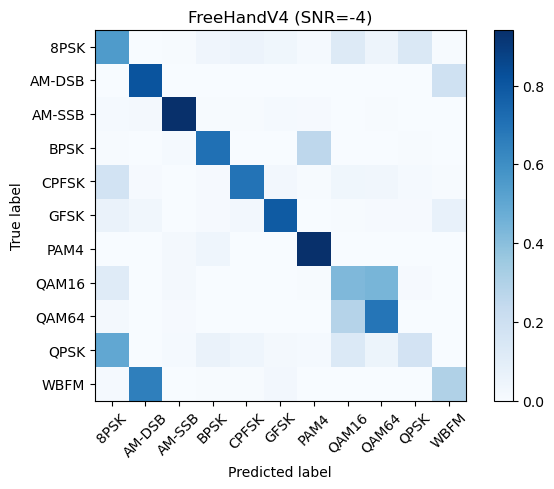

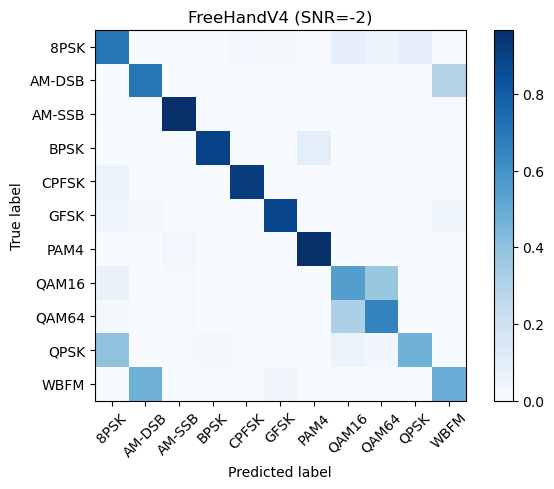

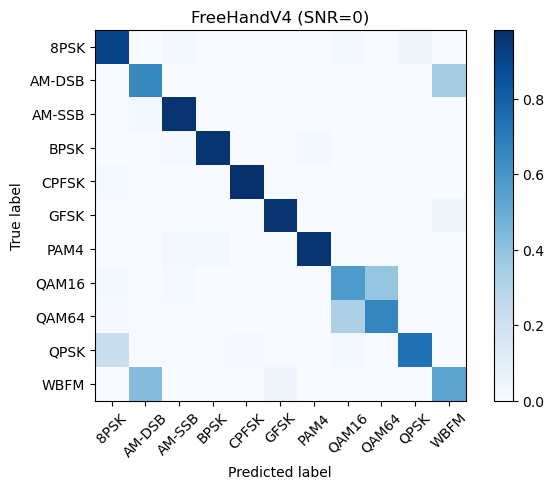

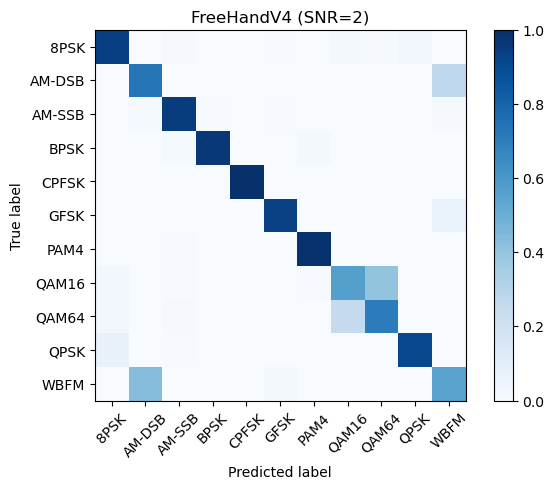

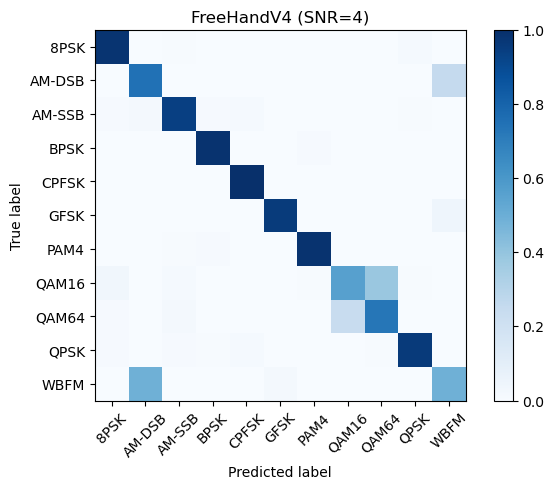

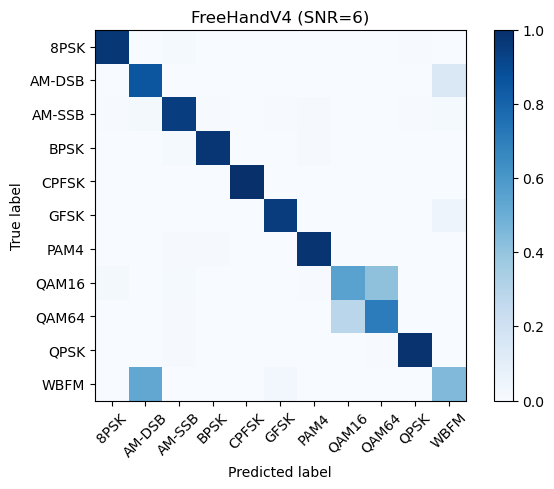

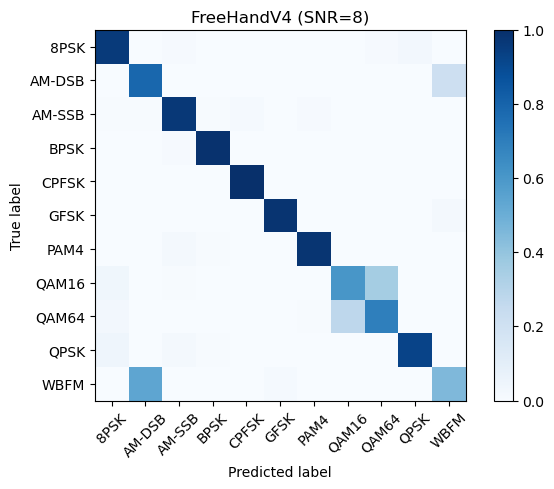

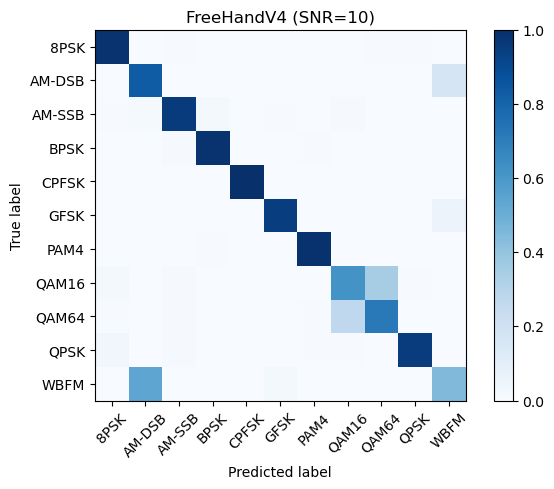

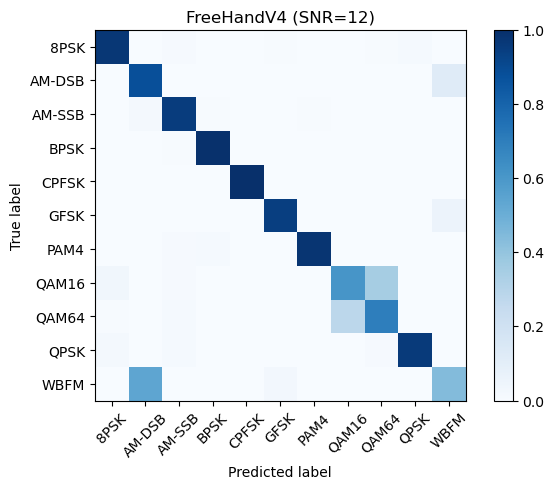

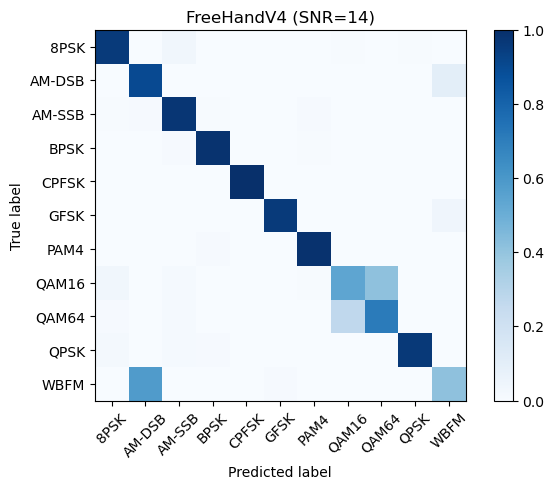

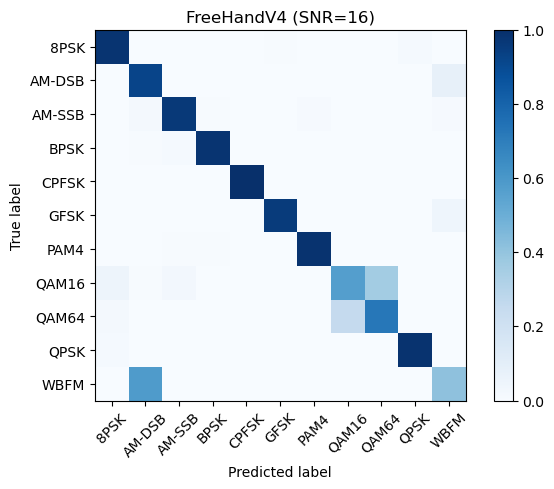

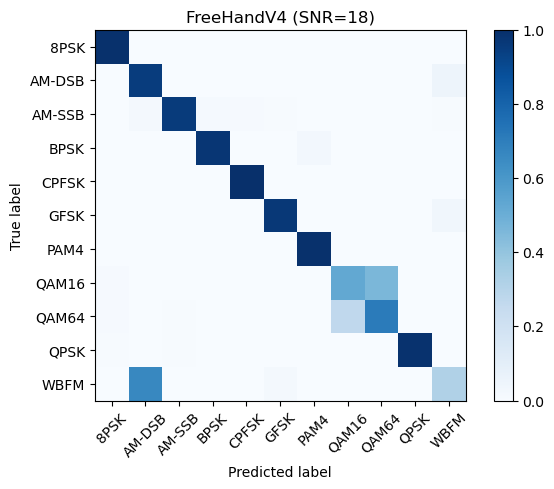

In [15]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [16]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,11,13,20,33,49,63,74,81,84,84,85,85,85,85,85,86,85


In [18]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )
# Save results to a pickle file for plotting later
import pickle

with open("FreeHandV4_IQ_history.pkl", "wb") as f:
    pickle.dump(history.history, f)
    
OUTPUT_FILENAME = 'FreeHandV4_IQ_acc.pkl'
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("FreeHand_v4_IQ", acc) , fd )

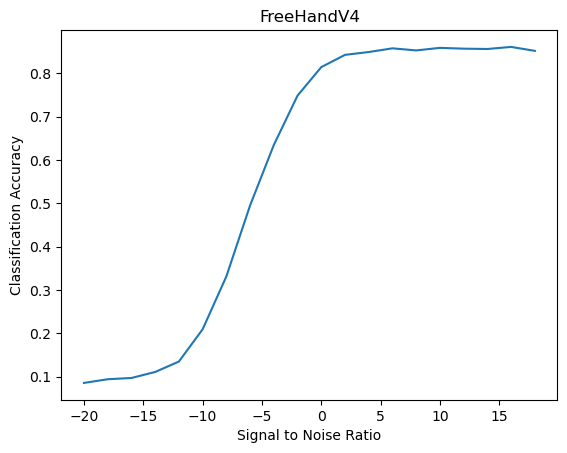

In [17]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)